# Classificação das imagens utilizando Vision Transformer (ViT)

## Arquitetura da Solução

## Dataset

O dataset escolhido está disponível no [link](https://www.kaggle.com/datasets/ahmedabdellahismail/covid-19-chest-x-ray/data), o qual é composto de **1196** imagens, pertencentes a três classes:

*   Covid
*   Virus
*   Normal



Segue abaixo o código necessário para realizar download do dataset, realizar unzip e excluir arquivos desnecessários:

In [1]:
!kaggle datasets download -d ahmedabdellahismail/covid-19-chest-x-ray
!unzip /content/covid-19-chest-x-ray.zip
!rm /content/covid-19-chest-x-ray.zip

Dataset URL: https://www.kaggle.com/datasets/ahmedabdellahismail/covid-19-chest-x-ray
License(s): Apache 2.0
 99% 364M/369M [00:13<00:00, 30.2MB/s]
100% 369M/369M [00:13<00:00, 29.3MB/s]
Archive:  /content/covid-19-chest-x-ray.zip
  inflating: Data.csv                
  inflating: Data/covid/100126173.png  
  inflating: Data/covid/101418710.jpg  
  inflating: Data/covid/10217856.png  
  inflating: Data/covid/102244181.jpeg  
  inflating: Data/covid/103445962.jpeg  
  inflating: Data/covid/104801348.jpeg  
  inflating: Data/covid/105435866.jpg  
  inflating: Data/covid/106531287.png  
  inflating: Data/covid/108711238.jpeg  
  inflating: Data/covid/11059951.png  
  inflating: Data/covid/111313983.png  
  inflating: Data/covid/112170361.jpeg  
  inflating: Data/covid/113381928.png  
  inflating: Data/covid/114316671.jpeg  
  inflating: Data/covid/115415399.png  
  inflating: Data/covid/116257521.jpeg  
  inflating: Data/covid/1163101.png  
  inflating: Data/covid/117705762.jpeg  
  infla

## Imports

In [2]:
!pip install torch
!pip install torchinfo

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [22]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import random
import torch
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
from torchvision import datasets, transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import torchvision
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [4]:
# selecionar a GPU caso exista
# ao selecionar a GPU, a tendencia é que o codigo seja executado mais rapidamente
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Transfer-Learning

### O que é?

É a técnica de utilizar um modelo pré-treinado para outra tarefa, a fim de adaptá-lo para ser a base para um outro modelo.

Nesse caso, utilizaremos o modelo ViT_B_16 para realizar classificação do presente dataset.

Treinar um modelo "*from scratch*" tornaria a tarefa de classificação muito menos acertiva, uma vez que a base de dados é pequena para tal, assim como a disponibilidade de recursos computacionais para treiná-lo.

### Overview

Primeiramente, serão carregados os pesos do modelo pré-treinado ViT_B_16, dessa forma, será utilizada uma técnica de **Transfer Learning**.


In [5]:
pretrained_vit_w = torchvision.models.ViT_B_16_Weights.DEFAULT  # pesos pre-treinados ViT-Base

In [6]:
print(pretrained_vit_w.transforms())  # transformações utilizadas no modelo-base

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## Pré-processamento dos dados

In [14]:
# Define a transformação a ser aplicada nas imagens
transform = pretrained_vit_w.transforms()

# Carrega o dataset da pasta, assumindo que as subpastas são as classes
dataset = datasets.ImageFolder(root="/content/Data/", transform=transform)

# Defina a proporção de dados de treinamento e teste
train_ratio = 0.7
validation_ratio = 0.15
# Calcula os tamanhos dos conjuntos de treino e teste
train_size = int(train_ratio * len(dataset))
validation_size = int(validation_ratio * len(dataset))
test_size = len(dataset) - train_size - validation_size
# Divide o dataset em conjuntos de treino e teste
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# Cria os data loaders para carregar os dados em mini-lotes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=True)


In [15]:
# Conta a quantidade de imagens por classe no conjunto de treinamento
train_class_count = {}

for _, label in train_dataset:
    if label in train_class_count:
        train_class_count[label] += 1
    else:
        train_class_count[label] = 1

# Conta a quantidade de imagens por classe no conjunto de validacao
validation_class_count = {}

for _, label in validation_dataset:
    if label in validation_class_count:
        validation_class_count[label] += 1
    else:
        validation_class_count[label] = 1

# Conta a quantidade de imagens por classe no conjunto de teste
test_class_count = {}
for _, label in test_dataset:
    if label in test_class_count:
        test_class_count[label] += 1
    else:
        test_class_count[label] = 1

# Mostra a quantidade de imagens por classe nos conjuntos de treinamento
print(f'Tamanho do conjunto de treino: {len(train_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de treinamento:")
for class_idx, count in train_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

# Mostra a quantidade de imagens por classe nos conjuntos de validação
print(f'\nTamanho do conjunto de validação: {len(validation_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de validação:")
for class_idx, count in validation_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

# Mostra a quantidade de imagens por classe nos conjuntos de teste
print(f'\nTamanho do conjunto de teste: {len(test_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de teste:")
for class_idx, count in test_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

Tamanho do conjunto de treino: 837
Quantidade de imagens por classe no conjunto de treinamento:
Classe 1: 329 imagens
Classe 2: 305 imagens
Classe 0: 203 imagens

Tamanho do conjunto de validação: 179
Quantidade de imagens por classe no conjunto de validação:
Classe 1: 70 imagens
Classe 2: 67 imagens
Classe 0: 42 imagens

Tamanho do conjunto de teste: 180
Quantidade de imagens por classe no conjunto de teste:
Classe 2: 61 imagens
Classe 1: 69 imagens
Classe 0: 50 imagens


## Definindo nosso modelo

In [16]:
pretrained_vit = torchvision.models.vit_b_16(    #utilizando o modelo-base, com os pesos padrao do modelo
    weights=pretrained_vit_w
    ).to(device)

class_names = dataset.classes #[covid, normal, virus]

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit.heads = nn.Linear(in_features=768, #16x16x3 = 768
                                 out_features=len(class_names)
                                 ).to(device)

In [17]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## Treino e Teste

In [20]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # colocar o modelo em modo de treinamento
    model.train()

    # inicializar valores com 0
    train_loss, train_acc = 0, 0

    # loop sobre os batches
    for batch, (X, y) in enumerate(dataloader):
        # enviar os dados para o device

        X, y = X.to(device), y.to(device)

        # forward
        y_pred = model(X)

        # calcular loss (e acumular)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # resetar o gradiente do otimizador antes do backpropagation
        optimizer.zero_grad()


        loss.backward()

        # ativar o otimizador
        optimizer.step()

        # calcular acuracia sobre os batches

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # ajustar as metricas para a media dos batches
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # coloca o modelo em modo eval
    model.eval()

    # iniciar valores com 0
    test_loss, test_acc = 0, 0

    # ligar inference context manager
    with torch.inference_mode():
        # loop sobre os batches
        for batch, (X, y) in enumerate(dataloader):
            # enviar os dados para o device
            X, y = X.to(device), y.to(device)

            # forward
            test_pred_logits = model(X)

            # calcular e "acumular" loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # calcular acuracia sobre os batches
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # ajustar as metricas para a media dos batches
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          eval_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # resultados
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    # loop pelos passos de treino e teste de acordo com o numero de epocas definido
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = eval_step(model=model,
          dataloader=eval_dataloader,
          loss_fn=loss_fn,
          device=device)

        # print para cada epoca
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

def predict(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:

    model.eval()

    all_preds = []
    all_targets = []

    with torch.inference_mode():
        # Passa por cada mini-lote
        for batch, (X, y) in enumerate(dataloader):
            # Envia os dados para o dispositivo de hardware
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            all_preds.append(y_pred)
            all_targets.append(y)

    # Concatena as predições e as classes
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    return all_preds, all_targets

In [21]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()
# setar seeds manualmente
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_loader,
                                      eval_dataloader=validation_loader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6391 | train_acc: 0.7356 | test_loss: 0.3134 | test_acc: 0.9235
Epoch: 2 | train_loss: 0.2870 | train_acc: 0.9190 | test_loss: 0.2224 | test_acc: 0.9339
Epoch: 3 | train_loss: 0.2297 | train_acc: 0.9363 | test_loss: 0.1793 | test_acc: 0.9479
Epoch: 4 | train_loss: 0.2347 | train_acc: 0.9428 | test_loss: 0.1558 | test_acc: 0.9479
Epoch: 5 | train_loss: 0.1765 | train_acc: 0.9549 | test_loss: 0.1450 | test_acc: 0.9531
Epoch: 6 | train_loss: 0.1578 | train_acc: 0.9618 | test_loss: 0.1336 | test_acc: 0.9635
Epoch: 7 | train_loss: 0.1480 | train_acc: 0.9590 | test_loss: 0.1264 | test_acc: 0.9652
Epoch: 8 | train_loss: 0.1321 | train_acc: 0.9653 | test_loss: 0.1195 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.1238 | train_acc: 0.9711 | test_loss: 0.1139 | test_acc: 0.9688
Epoch: 10 | train_loss: 0.1164 | train_acc: 0.9757 | test_loss: 0.1095 | test_acc: 0.9740


## Resultados

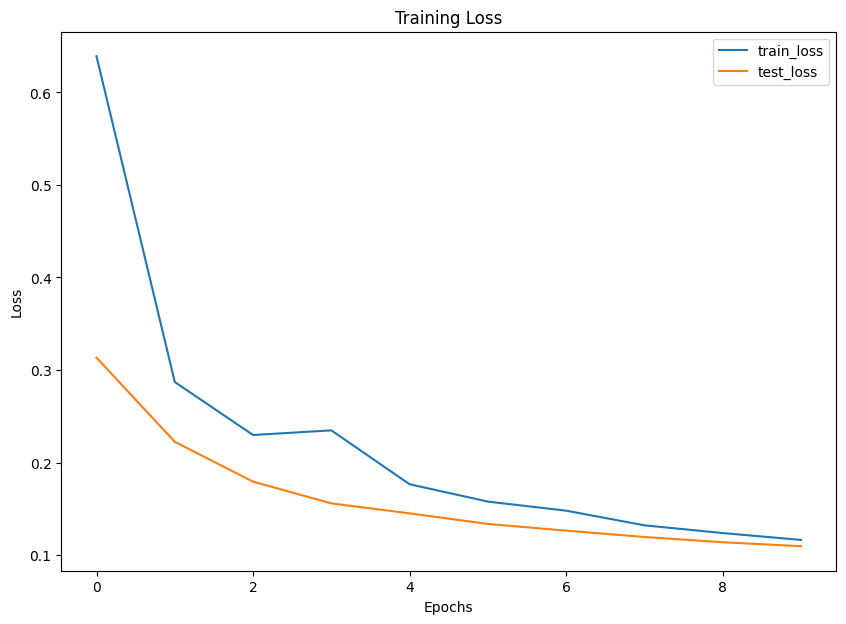

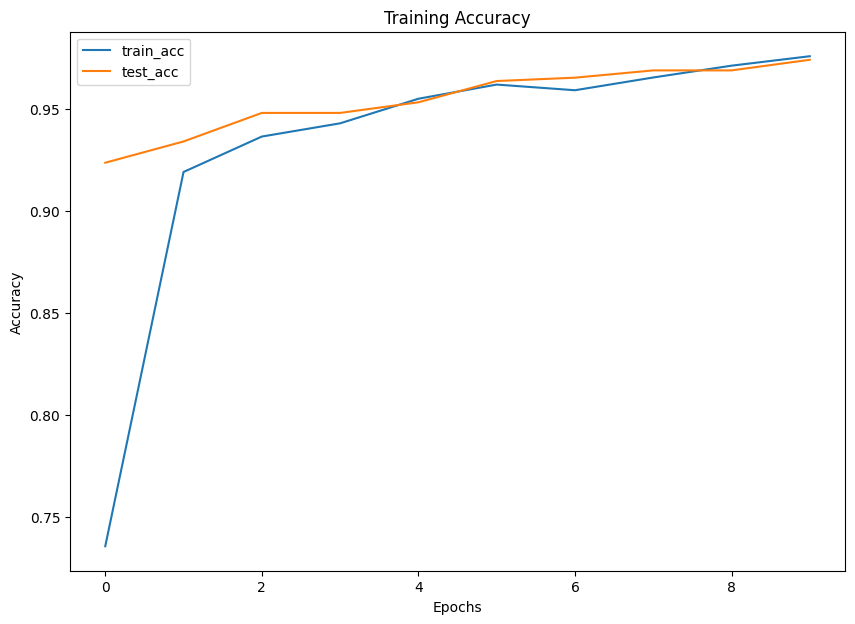

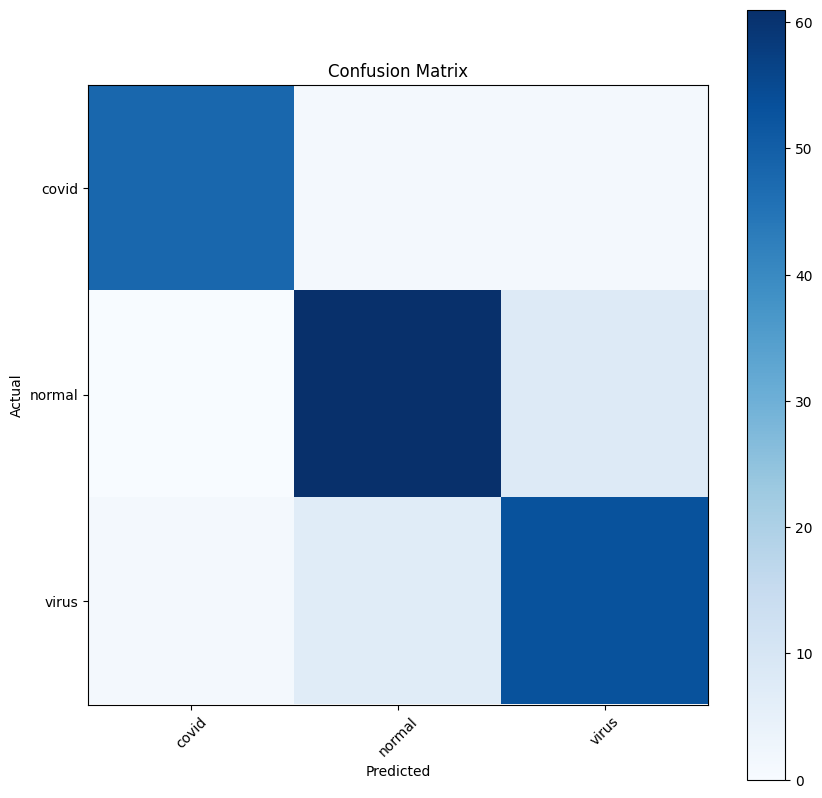

              precision    recall  f1-score   support

       covid       0.98      0.96      0.97        50
      normal       0.88      0.88      0.88        69
       virus       0.85      0.87      0.86        61

    accuracy                           0.90       180
   macro avg       0.91      0.90      0.91       180
weighted avg       0.90      0.90      0.90       180



In [26]:
## Avaliação do modelo

# Plota as métricas de treinamento
plt.figure(figsize=(10, 7))
plt.plot(pretrained_vit_results["train_loss"], label="train_loss")
plt.plot(pretrained_vit_results["test_loss"], label="test_loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(pretrained_vit_results["train_acc"], label="train_acc")
plt.plot(pretrained_vit_results["test_acc"], label="test_acc")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Realiza a predição no conjunto de teste
all_preds, all_targets = predict(model=pretrained_vit,
                                 dataloader=test_loader,
                                 device=device)

# Calcula a matriz de confusão
conf_matrix = confusion_matrix(all_targets.cpu(), all_preds.argmax(dim=1).cpu())

# Plota a matriz de confusão
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xticks(np.arange(3), class_names, rotation=45)
plt.yticks(np.arange(3), class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Imprime o classification report
print(classification_report(all_targets.cpu(), all_preds.argmax(dim=1).cpu(), target_names=class_names))